<a href="https://colab.research.google.com/github/ejnunn/GAN_Research/blob/main/SPAGAN_Faces_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/ejnunn/GAN_Research.git

Cloning into 'GAN_Research'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 56 (delta 28), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (56/56), done.


# Imports and Utils

## Library Imports

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm # progress bars
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # visualizations
import pandas as pd # data processing
import shutil # file management
import torch.nn.functional as F # used in Hyperparameters cell
from skimage import color
import numpy as np

# from GAN_Research.utils import *
# from GAN_Research.loss_functions import *

torch.manual_seed(0)

## Helper functions

In [4]:
# Compute the number of trainable parameters
def total_trainable_parameters(models):
  total = sum([len(x.parameters()) for x in models])
  return total

In [5]:
# Visualize images in a 2x2 grid.
# real_A | real_B
# fake_A | fake_B
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [6]:
# Save backup model weights to Google Drive account.
def save_model_to_drive(model, drive_dir):
  try:
    # Copy latest checkpoint to Drive for permenant storage
    save_filename = drive_dir + model.model_name
    torch.save({
      'gen_AB': model.gen_AB.state_dict(),
      'gen_BA': model.gen_BA.state_dict(),
      'gen_opt': model.gen_opt.state_dict(),
      'disc_A': model.disc_A.state_dict(),
      'disc_A_opt': model.disc_A_opt.state_dict(),
      'disc_B': model.disc_B.state_dict(),
      'disc_B_opt': model.disc_B_opt.state_dict()
    }, f"{save_filename}.pth")
  except:
    print('Need to mount a Google Drive account to runtime.')

In [7]:
def sum_of_abs_values_over_channels(tensor):
  '''
  Returns the sum of absolute values of activation maps in each
  spatial location in a layer across the channel dimention (dim=1)
  Parameters:
      tensor: PyTorch 4D-tensor of shape [batch_size, channels, height, width]
  '''
  abs_tensor = torch.abs(tensor)
  sum_tensor = torch.sum(abs_tensor, dim=1)
  return sum_tensor.unsqueeze(0)

In [8]:
def attn_map_norm_and_upsample(tensor, output_size):
  '''
  Return the normalized and upsampled attention map tensor.
  '''
  max_value = torch.max(tensor).item()
  normalized = torch.div(tensor, max_value)

  upsample = nn.Upsample(size=output_size)
  return upsample(normalized)

# ImageDataset Class

In [10]:
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

# Inspired by https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/datasets.py
class ImageDataset(Dataset):
    '''
    Parameters:
    max_size - limit dataset size to ensure effective epoch training duration
    '''
    def __init__(self, root, transform=None, mode='train', max_size=10000):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))[:max_size]
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))[:max_size]
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the correct images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))

        # Convert B&W images into RGB color
        if item_A.shape[0] != 3: 
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3: 
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

# Network architecture

## ResidualBlock Class

In [11]:
class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class:
    Performs two convolutions and an instance normalization, the input is added
    to this output to form the residual block output.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ResidualBlock: 
        Given an image tensor, completes a residual block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

## ContractingBlock Class

In [12]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs a convolution followed by a max pool operation and an optional instance norm.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs a convolutional transpose operation in order to upsample, 
        with an optional instance norm
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x



## FeatureMapBlock Class

In [13]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a Generator - 
    maps each the output to the desired number of output channels
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

## Generator Class

In [14]:
# third_tensor = torch.cat((first_tensor, second_tensor), 0)

class Generator(nn.Module):
    '''
    Generator Class
    A series of 2 contracting blocks, 9 residual blocks, and 2 expanding blocks to 
    transform an input image into an image from the other class, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        '''
        Function for completing a forward pass of Generator: 
        Given an image tensor, passes it through the U-Net with residual blocks
        and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)

        # attn_map = x13.clone()
        attn_map_norm = attn_map_norm_and_upsample(x13, target_shape)

        return self.tanh(xn), attn_map_norm

## Discriminator Class

In [15]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)

        # Copied from https://github.com/szagoruyko/attention-transfer/blob/master/visualize-attention.ipynb
        # Trying to get attention map for layer x3. Is this right?
        # x3 selected because it most likely correlates to discriminative object parts
        # attn_map = x3.pow(2).mean(1) # [g.pow(2).mean(1) for g in (g0, g1, g2, g3)]
        
        # Take features from 2nd to last layer and create attention map 
        # attn_map = x3.clone()
        attn_map_sum = sum_of_abs_values_over_channels(x3)
        attn_map_norm = attn_map_norm_and_upsample(attn_map_sum, target_shape)
        return xn, attn_map_norm

## SPAGAN Class

In [16]:
class SPAGAN():
  '''
  SPA-GAN model ready to train on Smile/Not Smile dataset from CelebA.

  Params:
    - weights_file: 
    - model_name: 
    - dim_A: Default model to accept RGB images
    - dim_B: B&W images will be broadcast to 3 dims
  '''
  def __init__(self, weights_file=None, model_name='smile', model_dir='drive/MyDrive/GAN Research/SPAGAN/models/smile/', dim_A=3, dim_B=3, \
               load_shape=286, target_shape=256, device='cuda', lr=0.0002):
    # Model Hyperparameters
    self.weights_file = weights_file
    self.model_name = model_name
    self.model_dir = model_dir
    self.device = device
    self.dim_A = dim_A
    self.dim_B = dim_B

    # Define model architecture
    self.gen_AB = Generator(self.dim_A, self.dim_B).to(self.device)
    self.gen_BA = Generator(self.dim_B, self.dim_A).to(self.device)
    self.gen_opt = torch.optim.Adam(list(self.gen_AB.parameters()) + list(self.gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
    self.disc_A = Discriminator(self.dim_A).to(self.device)
    self.disc_A_opt = torch.optim.Adam(self.disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
    self.disc_B = Discriminator(self.dim_B).to(self.device)
    self.disc_B_opt = torch.optim.Adam(self.disc_B.parameters(), lr=lr, betas=(0.5, 0.999))
    self.weights_file = weights_file # Filepath for pretrained weights
    
    # Load model weights
    if self.weights_file != None:
      self.load_weights(weights_file)
    else:
      self.random_weights()

  def random_weights(self):
    self.gen_AB = gen_AB.apply(self.weights_init)
    self.gen_BA = gen_BA.apply(self.weights_init)
    self.disc_A = disc_A.apply(self.weights_init)
    self.disc_B = disc_B.apply(self.weights_init)
  
  def weights_init(self, m):
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
          torch.nn.init.normal_(m.weight, 0.0, 0.02)
      if isinstance(m, nn.BatchNorm2d):
          torch.nn.init.normal_(m.weight, 0.0, 0.02)
          torch.nn.init.constant_(m.bias, 0)

  def load_weights(self, weights_file):
    self.model_dir = os.path.dirname(weights_file) # 'drive/MyDrive/GAN Research/SPAGAN/models/smile/'

    pre_dict = torch.load(latest_checkpoint)
    self.gen_AB.load_state_dict(pre_dict['gen_AB'])
    self.gen_BA.load_state_dict(pre_dict['gen_BA'])
    self.gen_opt.load_state_dict(pre_dict['gen_opt'])
    self.disc_A.load_state_dict(pre_dict['disc_A'])
    self.disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    self.disc_B.load_state_dict(pre_dict['disc_B'])
    self.disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])

  def train(self, dataloader, adv_criterion=nn.MSELoss(), recon_criterion=nn.L1Loss(), num_epochs=25, save_epoch=1, \
            fast_save=True, display_step=500, batch_size=1, is_inception=False):
    # Initialize local variables
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    cur_step = 0
    
    for epoch in range(num_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            ### Reshape images and load onto GPU ###
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(self.device)
            real_B = real_B.to(self.device)

            ### Feed input image to discriminator to get feature map ###
            _, real_A_fm = self.disc_A(real_A)
            _, real_B_fm = self.disc_B(real_B)

            ### Element-wise product of input image and feature map ###
            real_A_attn = torch.mul(real_A, real_A_fm)
            real_B_attn = torch.mul(real_B, real_B_fm)

            ### Update discriminator A ###
            self.disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A, _ = self.gen_BA(real_B_attn)
            disc_A_loss = get_disc_loss(real_A_attn, fake_A, self.disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) # Update gradients
            # disc_A_opt.step() # Update optimizer

            ### Update discriminator B ###
            self.disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B, _ = self.gen_AB(real_A_attn)
            disc_B_loss = get_disc_loss(real_B_attn, fake_B, self.disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) # Update gradients
            # disc_B_opt.step() # Update optimizer

            ### Update generator ###
            self.gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, real_A_attn, real_B_attn, self.gen_AB, self.gen_BA, \
                self.disc_A, self.disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            
            gen_loss.backward() # Update gradients
            
            ### Update optimizers ###
            # Error about "in-place" operations caused crashing
            # Updating optimizers AFTER all backprops fixed it
            self.disc_A_opt.step()
            self.disc_B_opt.step()
            self.gen_opt.step()

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A_attn, real_B_attn]), size=(self.dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([real_A, real_B]), size=(self.dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(self.dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if fast_save:
                    torch.save({
                        'gen_AB': self.gen_AB.state_dict(),
                        'gen_BA': self.gen_BA.state_dict(),
                        'gen_opt': self.gen_opt.state_dict(),
                        'disc_A': self.disc_A.state_dict(),
                        'disc_A_opt': self.disc_A_opt.state_dict(),
                        'disc_B': self.disc_B.state_dict(),
                        'disc_B_opt': self.disc_B_opt.state_dict()
                    }, f"{self.model_name}_{cur_step}.pth")

            ### Save to Google Drive ###
            if epoch % save_epoch == 0:
              filename =  self.model_name + '_' + str(epoch)
              save_model_to_drive(self, filename)

            cur_step += 1



## Loss Functions

### Get Discriminator Loss

In [17]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        real_X: the real images from pile X
        fake_X: the generated images of class X
        disc_X: the discriminator for class X; takes images and returns real/fake class X
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the target labels and returns a adversarial 
            loss (which you aim to minimize)
    '''

    fake_X.detach()
    fake_pred, _ = disc_X(fake_X)
    fake_loss = adv_criterion(fake_pred, torch.zeros_like(fake_pred))
    real_pred, _ = disc_X(real_X)
    real_loss = adv_criterion(real_pred, torch.ones_like(real_pred))
    disc_loss = (fake_loss + real_loss) / 2.0

    return disc_loss

### Get Generator Adversarial Loss

In [18]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Return the adversarial loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        disc_Y: the discriminator for class Y; takes images and returns real/fake class Y
            prediction matrices
        gen_XY: the generator for class X to Y; takes images and returns the images 
            transformed to class Y
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the target labels and returns a adversarial 
                  loss (which you aim to minimize)
    '''

    fake_Y, _ = gen_XY(real_X)
    pred_Y, _ = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(pred_Y, torch.ones_like(pred_Y))

    return adversarial_loss, fake_Y

### Get Identity Loss

In [19]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    '''
    Return the identity loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        identity_criterion: the identity loss function; takes the real images from X and
                        those images put through a Y->X generator and returns the identity 
                        loss (which you aim to minimize)
    '''

    identity_X, _ = gen_YX(real_X)
    identity_loss = identity_criterion(real_X, identity_X)

    return identity_loss, identity_X

### Get Cycle Consistency Loss

In [20]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Return the cycle consistency loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        fake_Y: the generated images of class Y
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
                        those images put through a X->Y generator and then Y->X generator
                        and returns the cycle consistency loss (which you aim to minimize)
    '''

    cycle_X, _ = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(real_X, cycle_X)

    return cycle_loss, cycle_X

### Get feature map loss

In [21]:
# Feature Map loss function for SPA-GAN
# See page 4 of SPA-GAN paper for details
# URL: https://arxiv.org/pdf/1908.06616v3.pdf

def get_fm_loss(real_X, fake_Y, gen_XY):
  '''
  Return feature map loss between real and fake feature maps.
  Parameters:
      real_fm_X: the real feature map from pile X
                 shape = [batch_size, channels, height, width]
      fake_fm_X: the generated feature map from class X
                 shape = [batch_size, channels, height, width]
      gen_XY: the generator for class X to Y; takes input images and returns the images
          transformed to class Y
  '''
  # Feature maps of real image x_a and generated image y'_a.
  real_X.detach()
  
  _, real_fm_X = gen_XY(real_X)
  _, fake_fm_Y = gen_XY(fake_Y)

  total = 0
  for i in range(real_fm_X.shape[1]):
    # i-th feature maps
    fm_X_i = real_fm_X[0][i] # [0] <- batch size of one
    fm_Y_i = fake_fm_Y[0][i]

    # L1 norm of the difference.
    total = total + torch.linalg.norm(fm_X_i - fm_Y_i)

  # Finally, average over number of feature maps (C) in the given layer of G.
  fm_loss = torch.div(total, real_fm_X.shape[1])

  return fm_loss

### Get Generator Loss

In [22]:
def get_gen_loss(real_A, real_B, real_A_attn, real_B_attn, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10, lambda_fm=0.1):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        real_A: the real images from pile A
        real_B: the real images from pile B
        gen_AB: the generator for class A to B; takes images and returns the images 
            transformed to class B
        gen_BA: the generator for class B to A; takes images and returns the images 
            transformed to class A
        disc_A: the discriminator for class A; takes images and returns real/fake class A
            prediction matrices
        disc_B: the discriminator for class B; takes images and returns real/fake class B
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the true labels and returns a adversarial 
            loss (which you aim to minimize)
        identity_criterion: the reconstruction loss function used for identity loss
            and cycle consistency loss; takes two sets of images and returns
            their pixel differences (which you aim to minimize)
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
            those images put through a X->Y generator and then Y->X generator
            and returns the cycle consistency loss (which you aim to minimize).
            Note that in practice, cycle_criterion == identity_criterion == L1 loss
        lambda_identity: the weight of the identity loss
        lambda_cycle: the weight of the cycle-consistency loss
        lambda_fm: the weight of the feature-map loss
    '''

    # Adversarial Loss -- get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion)
    adv_loss,fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    adv_loss_2,fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    
    # Identity Loss -- get_identity_loss(real_X, gen_YX, identity_criterion)
    ide_loss,identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    ide_loss_2,identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)

    # Cycle-consistency Loss -- get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion)
    cyc_loss,cycle_A = get_cycle_consistency_loss(real_A_attn, fake_B, gen_BA, cycle_criterion)
    cyc_loss_2,cycle_B = get_cycle_consistency_loss(real_B_attn, fake_A, gen_AB, cycle_criterion)
    
    # Feature-Map Loss -- get_fm_loss(real_X, fake_Y, gen_XY)
    fm_loss = get_fm_loss(real_A, fake_B, gen_AB)
    fm_loss_2 = get_fm_loss(real_B, fake_A, gen_BA)
    
    # Total loss
    gen_loss = adv_loss + adv_loss_2 + lambda_identity * (ide_loss + ide_loss_2) +  \
          lambda_cycle * (cyc_loss + cyc_loss_2) + lambda_fm * (fm_loss + fm_loss_2)

    return gen_loss, fake_A, fake_B

### Criterion

In [23]:
## Criterion for adversarial loss and reconstruction loss
adv_criterion = nn.MSELoss() 
recon_criterion = nn.L1Loss()

# Training

## Load Smile Dataset

In [24]:
## Create two groups of image files, smiling and not smiling ##

# Create dataframe to sort CelebA images
img_dir_celeba = '/content/drive/MyDrive/GAN Research/SPAGAN/Images/CelebA/'
attr_filename = 'list_attr_celeba.txt'

df = pd.read_csv(img_dir_celeba + attr_filename, skiprows=1, delim_whitespace=True)
df = df.reset_index()
df.rename(columns={'index': 'filename'}, inplace=True)

# Lists of smiling and non-smiling image filenames
smiling_list = list(df[['filename']].loc[df['Smiling'] == 1]['filename'])
not_smiling_list = list(df[['filename']].loc[df['Smiling'] == -1]['filename'])

In [25]:
## Create two groups of image files, smiling and not smiling ##

# Create dataframe to sort CelebA images
img_dir_celeba = '/content/drive/MyDrive/GAN Research/SPAGAN/Images/CelebA/'
attr_filename = 'list_attr_celeba.txt'

df = pd.read_csv(img_dir_celeba + attr_filename, skiprows=1, delim_whitespace=True)
df = df.reset_index()
df.rename(columns={'index': 'filename'}, inplace=True)

# Lists of smiling and non-smiling image filenames
smiling_list = list(df[['filename']].loc[df['Smiling'] == 1]['filename'])
not_smiling_list = list(df[['filename']].loc[df['Smiling'] == -1]['filename'])

## Unzip images and move files into the correct category ##

# Unzip images from drive and store in current directory
!unzip -q /content/drive/MyDrive/GAN\ Research/SPAGAN/Images/CelebA/img_align_celeba.zip

# Create training A and B subdirectories
!mkdir img_align_celeba/trainA
!mkdir img_align_celeba/trainB

# Move images into correct subdirectory
try:
  source_dir = 'img_align_celeba/'
  destination_dir = 'img_align_celeba/trainA'
  for img in smiling_list:
    shutil.move(source_dir + img, destination_dir)

  source_dir = 'img_align_celeba/'
  destination_dir = 'img_align_celeba/trainB'
  for img in not_smiling_list:
    shutil.move(source_dir + img, destination_dir)
  print('images loaded successfully!')
except:
  print('Images already loaded')

## Load files into a Image Dataset object ##
load_shape = 286 # originally 286. Why?
target_shape = 256 # originally 256

# Apply transforms to dataset to augment
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

img_dir = 'img_align_celeba'
training_max_images = 2000
dataset = ImageDataset(img_dir, transform=transform, max_size=training_max_images)

print("Size of dataset: {} images".format(len(dataset)))

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
print('Dataloader created')

images loaded successfully!
Size of dataset: 2000 images
Dataloader created


## Define model and load weights

In [26]:
# Get most recent file based on days of training
model_dir = '/content/drive/MyDrive/GAN Research/SPAGAN/models/smile/'
list_of_files = glob.glob(model_dir + "*") # * means all if need specific format then *.csv
latest_checkpoint = max(list_of_files, key=os.path.getctime)
print(latest_checkpoint)

spagan = SPAGAN(weights_file=latest_checkpoint, model_name='smile', device='cuda')
print('model created')

/content/drive/MyDrive/GAN Research/SPAGAN/models/smile/smile_3.pth
model created


## Train model

Epoch 0: Step 0: Generator (U-Net) loss: 0.002400008201599121, Discriminator loss: 0.0004115242063999176


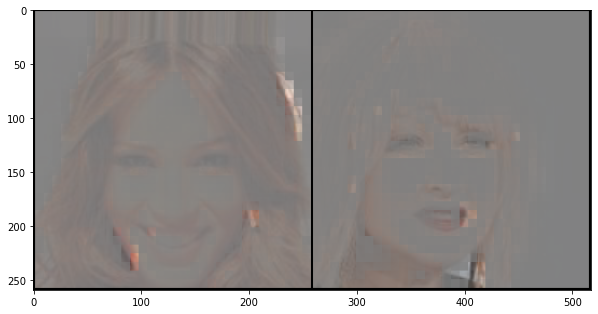

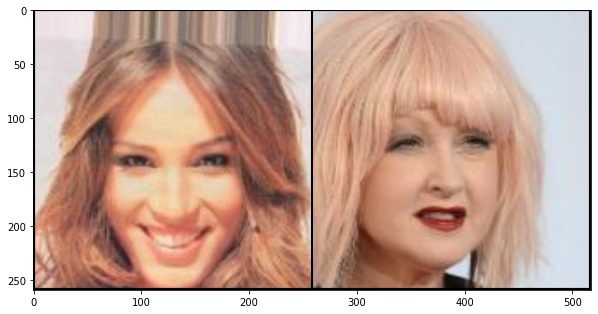

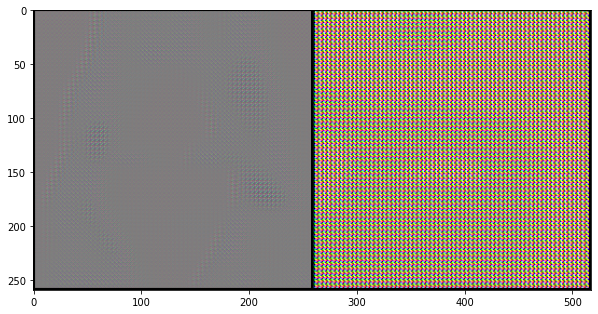

Epoch 0: Step 500: Generator (U-Net) loss: 1.0548998492956168, Discriminator loss: 0.2186786755770447


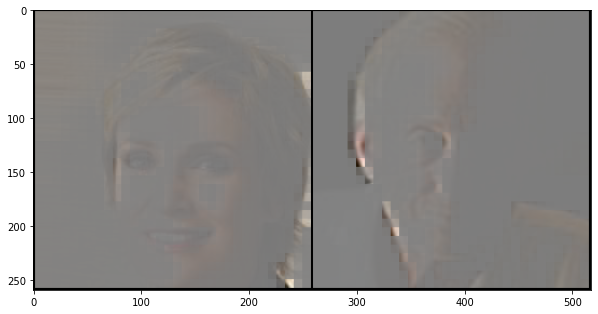

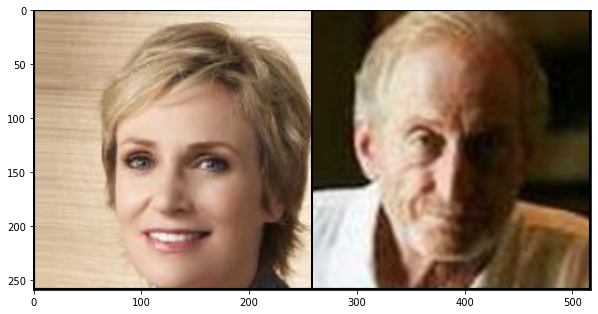

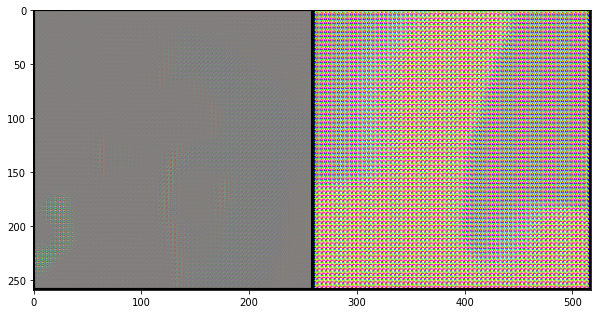

Epoch 0: Step 1000: Generator (U-Net) loss: 1.01693935239315, Discriminator loss: 0.21075337103009245


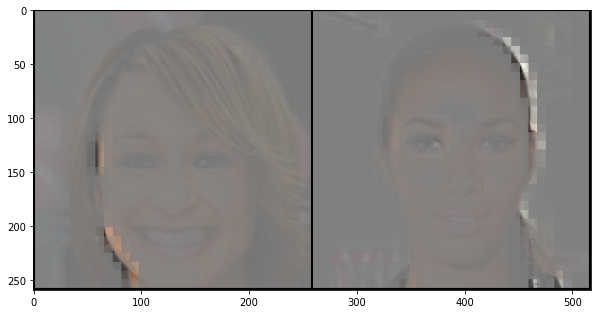

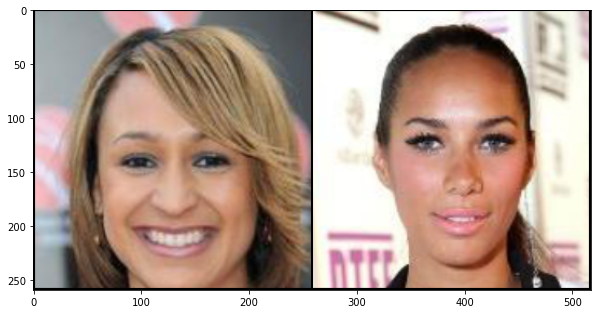

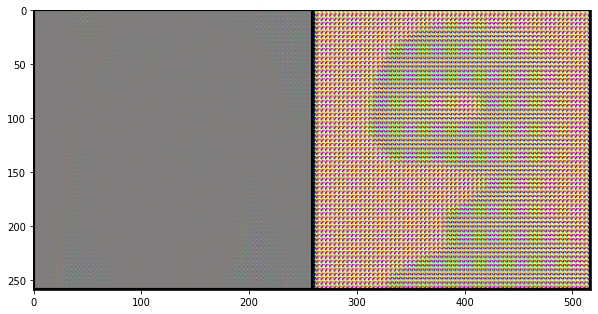

In [ ]:
torch.cuda.empty_cache()
plt.rcParams["figure.figsize"] = (10, 10)
torch.autograd.set_detect_anomaly(True)

spagan.train(dataloader=dataloader)

## Start training

In [ ]:
# torch.cuda.empty_cache()
# plt.rcParams["figure.figsize"] = (10, 10)
# torch.autograd.set_detect_anomaly(True)

# # train(epochs=20, save_model=True, save_epoch=1, display_step=500)
# train_model(spagan, dataloader, criterion, optimizer, num_epochs=25, save_epochs=1, display_step=500, batch_size=1, is_inception=False):

## Save final model weights

In [ ]:
final_model_name = 'test_before_OOP'
save_model_to_drive(spagan, final_model_name, model_dir)

# Testing

## Train Model (old version)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def train(save_model=False, save_epoch=1):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            ### Reshape images and load onto GPU ###
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Feed input image to discriminator to get feature map ###
            _, real_A_fm = disc_A(real_A)
            _, real_B_fm = disc_B(real_B)

            ### Element-wise product of input image and feature map ###
            real_A_input = torch.mul(real_A, real_A_fm)
            real_B_input = torch.mul(real_B, real_B_fm)

            ### Update discriminator A ###
            self.disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A, _ = self.gen_BA(real_B_input)
            disc_A_loss = get_disc_loss(real_A_input, fake_A, self.disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) # Update gradients
            # disc_A_opt.step() # Update optimizer

            ### Update discriminator B ###
            self.disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B, _ = self.gen_AB(real_A_input)
            disc_B_loss = get_disc_loss(real_B_input, fake_B, self.disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) # Update gradients
            # disc_B_opt.step() # Update optimizer

            ### Update generator ###
            self.gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, real_A_input, real_B_input, self.gen_AB, self.gen_BA, \
                self.disc_A, self.disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            
            gen_loss.backward() # Update gradients
            
            ### Update optimizers ###
            # Error about "in-place" operations caused crashing
            # Updating optimizers AFTER all backprops fixed it
            self.disc_A_opt.step()
            self.disc_B_opt.step()
            self.gen_opt.step()

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A_input, real_B_input]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_{cur_step}.pth")

            ### Save to Google Drive ###
            if epoch % save_epoch == 0:
              filename =  model_name + '_' + str(epoch)
              save_model_to_drive(filename, model_dir)

            cur_step += 1

## Debugging and Random Tests

In [ ]:
i = 0
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for real_A, real_B in dataloader:
  if i > 0:
    break
  
  real_A = nn.functional.interpolate(real_A, size=target_shape)
  real_B = nn.functional.interpolate(real_B, size=target_shape)
  cur_batch_size = len(real_A)
  real_A = real_A.to(device)
  real_B = real_B.to(device)
  
  _, real_A_fm = disc_A(real_A)
  real_A_input = torch.mul(real_A, real_A_fm)
  _, real_B_fm = disc_B(real_B)
  real_B_input = torch.mul(real_B, real_B_fm)

  fake_A, fake_A_fm = gen_BA(real_B)
  fake_B, fake_B_fm = gen_AB(real_A)

  ### Check shape of generated feature maps ###
  print(real_A_input.shape)
  print(fake_A_fm.shape)
  
  show_tensor_images(torch.cat([real_A_input, real_B_input]), size=(dim_A, target_shape, target_shape))
  show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
  show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
               

  i += 1

In [ ]:
from PIL import Image

a = torch.rand([1,512,16,16])
print(a.shape)

b = sum_of_abs_values_over_channels(a)
print(b.shape)

c = attn_map_norm_and_upsample(b, target_shape)
print(c.shape)

d = c.squeeze()
print(d.shape)

to_pil = torchvision.transforms.ToPILImage()
img = to_pil(d)

plt.imshow(img, interpolation=)